# Improved Bound Constraint differing across domain

We are interested still in protecting just the outputs. Reiterating the previous paper, we need to find:

$$||f_D(x_*) - f_{D'}(x_*)||^2_H$$

We can express this difference as:

$$f_D(x_*) - f_{D'}(x_*) = \sum_{i=1}^n k(x_*,x_i) \; (\alpha_i - \alpha_i')$$

We also noted that 
$$\mathbf{\alpha} - \mathbf{\alpha}' = K^{-1} (\mathbf{y}-\mathbf{y}')$$

The change we propose at this point is that, rather than just put a bound on the values of $k(\cdot,\cdot)$ we calculate these values for every test point.

So rather than just accept that $-1<k(\cdot,\cdot)<1$ we actually input the value of this function. 

Thus the bound is:

$$\text{max}_j\; \text{abs}\left( \sum_{i=1}^n { k(x_*,x_i) \; (K^{-1})_{ij} } \right) \Delta_y$$

So we need to calculate the kernel value from a test point $x_*$ to each training point $x_i$ (shape, transposed, 1xN). Such a vector will then be multiplied by $K^{-1}$ (NxN) such that each column is multiplied element wise with the $k$s. The resulting 1xN vector is the result of whether the differing element of $\mathbf{y}$ lies at that index. We find the absolute change, as that's what we want to protect. Find the largest of these, and then scale by the largest change in y.

$$\text{max} \; \left[ \text{abs} \left(\mathbf{k}_*^{\top} \mathbf{K}^{-1} \right) \right] \Delta_y$$

For speed we can consider the matrix of covariance between all test and training points $\mathbf{K}_*$, we want the maximum of each row:

$$\text{max}_{by\;row} \; \left[ \text{abs} \left(\mathbf{K}_*^{\top} \mathbf{K}^{-1} \right) \right] \Delta_y$$

### Inducing inputs using the improved bound constraint

We need to apply the above to inducing inputs. We just need to consider the calculation of $\mathbf{\alpha}$ for the inducing inputs, and then use the same expression as above.

From the paper,

$\mu_* = \mathbf{k}_*^\top Q_{uu}^{-1} K_{uf} \left( \Lambda + \sigma^2 I \right)^{-1} \mathbf{y}$

where $Q_{uu} = K_{uu} + K_{uf}\left( \Lambda + \sigma^2 I \right)^{-1} K_{fu}$ and the matrix $\Lambda = \text{diag}(\mathbf{\lambda})$ where the diagonal elements are $\lambda_i = K_{ii} - \mathbf{k}_i^\top K_{uu}^{-1} \mathbf{k}_i$.

So we just need to substitute in,

$\mathbf{K}_{pseudo}^{-1} = Q_{uu}^{-1} K_{uf} \left( \Lambda + \sigma^2 I \right)^{-1}$

thus,

$$\text{max}_{by\;row} \; \left[ \text{abs} \left(\mathbf{K}_*^{\top} \mathbf{K}_{pseudo}^{-1} \right) \right] \Delta_y$$

where $\mathbf{K}_*$ is now the covariance between inducing inputs and test inputs.

Applying this to the fish length example;

warning in stationary: failed to import cython module: falling back to numpy


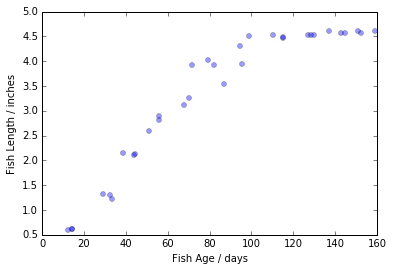

In [1]:
import dp4gp_datasets as datasets
import dp4gp
import GPy

import pandas as pd
import dp4gp_datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import dp4gp

fishdata = datasets.load_fishlength()

X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
plt.plot(X,Y,'o',alpha=0.4,markersize=5)
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')


In [ ]:
test_inputs = np.arange(0,260,1)
pseudo_inputs = np.array([0,40,80,120,160])
lengthscales = 20.0
sigma = 0.1

test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)

We now have four results,

- normal GP
- inducing variable GP
- normal GP, but with the kernel computed for each test point (i.e. test point specific)
- test point specific IV GP

The results for the above fish example are as follows;

In [ ]:
print("Normal GP     %03.3f" % normal_msense)
print("IV GP         %3.3f" % pseudo_msense)
print("TPS normal GP %3.3f" % np.mean(normal_peroutput_msense))
print("TPS IV GP     %3.3f" % np.mean(pseudo_peroutput_msense))

The TPS do far better on average (although it depends on which points you care about! The figure below illustrates how the sensitivity varies. The horizontal line near the top indicates the sensitivity of the IV GP.

In [ ]:
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.1)
#plt.hlines(pseudo_msense,0,250)

The vertical lines along the bottom of the figure indicate where the training data is.

Note that the sensitivity increases beyond the last set of data. I assume this is because these test points depend on fewer training data, and so are more easily altered by single training point values. To further demonstrate this we add a new fish of 200 days,

In [ ]:
X = np.hstack([200,X])
Y = np.hstack([10,Y])
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)


In [ ]:
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.1)
plt.hlines(pseudo_msense,0,250)

In [ ]:
print("Normal GP     %03.3f" % normal_msense)
print("IV GP         %3.3f" % pseudo_msense)
print("TPS normal GP %3.3f" % np.mean(normal_peroutput_msense))
print("TPS IV GP     %3.3f" % np.mean(pseudo_peroutput_msense))

One can see that the sensitivity of the normal GP is greatest around this single outlying training point. The inducing input GP is protected from this as there are no inducing inputs near the training point.

This method seems to have many intuitive features;

 - the sensitivity approaches zero far from the training data (where we return to the GP prior).
 - conversely, the more training data in a locale, the less the sensitivity too. However, this seems to sometimes be cancelled out by increased sensitivity in the surrounding area, presumably the effect of the gradient of the mean can still be strongly affected by individual training point, as one moves away from a concentration of training data?
 - we can reduce the sensitivity by placing inducing inputs near the higher concentrations of training points, and away from single outliers. This might explain why the TPS IV GP method above did poorly;
 
To further investigate these points, we add 9 more points and an inducing input, all around 200 days;

In [ ]:
X = np.hstack([201,199,198,196,202,204,205,206,208,X])
Y = np.hstack([10,12,13,14,15,16,14,13,11,Y])
pseudo_inputs = np.array([0,40,80,120,160,200])

test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)


In [ ]:
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.1)
plt.hlines(pseudo_msense,0,250)

In [ ]:
pseudo_inputs = np.array([17,42,72,98,125,140,170,200])
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.1)
plt.hlines(pseudo_msense,0,250)

The inducing variables potentially are useful in situations with lots of outliers, or higher numbers of dimensions.

### Demo with outputs

0.49718654173901899

Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Calculating K_NN
Calculating lambda
0.481434667366
0.3507048708
15.4892032056


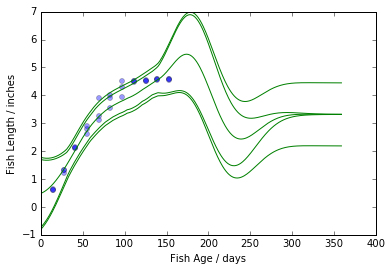

In [100]:
fishdata = datasets.load_fishlength()

test_inputs = np.arange(0,360,1)
pseudo_inputs = np.array([0,40,80,120,160])
lengthscales = 50.0
sigma = 0.3

X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
plt.plot(X,Y,'o',alpha=0.4,markersize=5)

ymean = np.mean(Y)
ystd = np.std(Y)
Y-=ymean
Y/=ystd

X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')

m = GPy.models.GPRegression(X[:,None],Y[:,None]-np.mean(Y))
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
delta = 0.01
eps = 2.0
sens = 2.0

test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)

preds = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, normal_peroutput_msense, sens=sens, delta=delta, eps=eps)

print np.max(pseudo_peroutput_msense)
print np.max(normal_peroutput_msense)
print pseudo_msense


y,var = m.predict(test_inputs[:,None])
y*=ystd
y+=ymean

#plt.plot(test_inputs, y,'-g')
#plt.plot(test_inputs, y+np.sqrt(var),'-g')
#plt.plot(test_inputs, y-np.sqrt(var),'-g')


noise_shape = normal_peroutput_msense[:,None]*sens*np.sqrt(2*np.log(2/delta))/eps

preds*=ystd
preds+=ymean
noise_shape*=ystd
var*=np.sqrt(ystd)
plt.plot(test_inputs, preds[:,None])
plt.plot(test_inputs, preds[:,None]+noise_shape,'-g');
plt.plot(test_inputs, preds[:,None]-noise_shape,'-g');
plt.plot(test_inputs, preds[:,None]+np.sqrt(noise_shape**2+var),'-g'); 
plt.plot(test_inputs, preds[:,None]-np.sqrt(noise_shape**2+var),'-g');




### Demonstration of why there's such a large noise added to 'ends' of training data

I think this happens because the last point can influence the gradient quite a bit, which means that the curve's location can move a lot even with a small change in a data point, it's effectively being magnified by the fulcrum of the data before it.

1.6275130649721945

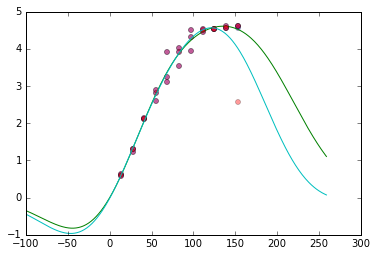

In [79]:
fishdata = datasets.load_fishlength()
test_inputs = np.arange(-100,260,1)
pseudo_inputs = np.array([0,40,80,120,160])
lengthscales = 60.0
sigma = 0.2
X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
plt.plot(X,Y,'o',alpha=0.4,markersize=5)


m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
y,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],y)

Y[-1] -= 2
plt.plot(X,Y,'o',alpha=0.4,markersize=5)

m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
newy,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],newy)

np.max(np.abs(newy-y))

0.36664829213805783

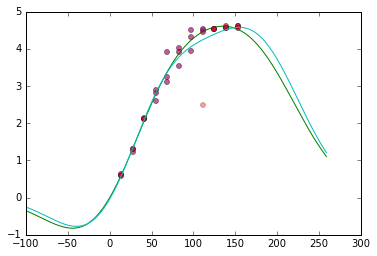

In [80]:
fishdata = datasets.load_fishlength()
test_inputs = np.arange(-100,260,1)
pseudo_inputs = np.array([0,40,80,120,160])
lengthscales = 60.0
sigma = 0.2
X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
plt.plot(X,Y,'o',alpha=0.4,markersize=5)


m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
y,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],y)

Y[18] -= 2
plt.plot(X,Y,'o',alpha=0.4,markersize=5)

m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
newy,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],newy)

np.max(np.abs(newy-y))

We can see that moving a point near the end of the dataset can cause a much larger change in the posterior mean (maximum change is 4.4 times larger).